# Week 5: Tractable Generative Models

### Author: Rajit Rajpal

The goal of this tutorial will be to learn about tractable generative models (e.g Autoregressive, Normalizing Flows) that give exact likelihoods to perform tasks like out-of-distribution (OOD) detection. `# TODO` are for you to implement. Solutions will contain the completed code.

### Imports

In [1]:
# %pip install numpy matplotlib torch torchvision scipy pillow scikit-learn <- Uncomment and run this if you do not have the necessary packages.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import PIL.Image

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1 Autoregressive Model

The core idea of an autoregressive model is to decompose the joint distribution of a
$D$-dimensional vector $x$ into a product of conditional distributions using the
chain rule of probability:

$$
p(x) = \prod_{i=1}^{D} p(x_i \mid x_{<i})
$$

where
$$
x_{<i} = [x_1, \dots, x_{i-1}].
$$

We will be using the binarized MNIST dataset, the same as last time except each pixel is either 0 (black) or 1 (white). This is done in order to facilitate quick training.
For binarized MNIST, each $x_i$ is a Bernoulli random variable. The model outputs the
probability
$$
\theta_i = p(x_i = 1 \mid x_{<i}).
$$

### Autoregressive Constraint

To compute this in a single forward pass, we use MADE. We apply *masks* to the weight
matrices of a standard MLP to ensure that a hidden unit $h_j$ only depends on a subset
of inputs, and the output $\hat{x}_i$ depends only on
$x_1, \dots, x_{i-1}$.

### Loss Function (Negative Log-Likelihood)

For binarized data, we minimize the binary cross-entropy:

$$
\mathcal{L}(x) =
- \sum_{i=1}^{D}
\left[
x_i \log \hat{x}_i + (1 - x_i)\log(1 - \hat{x}_i)
\right].
$$


### 1.1 Architecture

We need a custom Linear layer that can zero out specific connections to enforce the autoregressive property.

In [2]:
class MaskedLinear(nn.Linear):
    """ A linear layer with a configurable mask to enforce autoregressive constraints """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype('float32')))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

We use a model called MADE (masked autoregressive density estimator). We won't go too much in detail regarding the implementation of this architecture. The basic idea is:

A standard autoencoder takes an input vector $x$ and predicts a reconstruction $\hat{x}$. However, in a fully connected architecture, the predicted component $\hat{x}_i$ may depend on $x_i$ itself (or even on future variables $(x_{i+1}, \dots)$), which violates the autoregressive requirement needed to model $p(x_i \mid x_{<i})$.

MADE enforces autoregressive structure by applying a binary mask $M$ to the weight matrix $W$ of each layer, restricting which connections are allowed. The resulting transformation is
$$
h = \text{activation}\left((W \odot M)x + b\right),
$$
where the mask ensures that each output dimension depends only on the appropriate subset of inputs. By carefully constructing these masks, MADE guarantees that the network represents a valid autoregressive model while retaining the efficiency of a single forward pass.

Please refer to this paper (https://arxiv.org/abs/1502.03509) for more detail.


In [3]:
class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.net = nn.Sequential()
        
        # Build the network
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = []
        for i in range(len(dims)-1):
            m_layer = MaskedLinear(dims[i], dims[i+1])
            self.net.add_module(f"layer_{i}", m_layer)
            self.layers.append(m_layer)
            if i < len(dims)-2:
                self.net.add_module(f"relu_{i}", nn.ReLU())
        
        self.m = {}
        self.create_masks()

    def create_masks(self):
        L = len(self.layers)
        # Assign degrees to input nodes: 1 to D
        self.m[-1] = np.arange(1, self.input_dim + 1)
        
        # Degrees for hidden layers: random integers between 1 and D-1
        for l in range(L - 1):
            self.m[l] = np.random.randint(1, self.input_dim, size=self.layers[l].out_features)
            
        # The output layer degrees must match the input degrees for the auto-regressive property
        self.m[L-1] = np.arange(1, self.input_dim + 1)
        
        # Apply masks to the MaskedLinear layers
        for l in range(L):
            # Mask logic: hidden unit j can only see input units i where m(i) <= m(j)
            # For the output layer, it's a strict inequality: m(i) < m(j)
            if l < L - 1:
                mask = self.m[l-1][None, :] <= self.m[l][:, None]
            else:
                mask = self.m[l-1][None, :] < self.m[l][:, None]
            
            self.layers[l].set_mask(mask)

    def forward(self, x):
        return self.net(x)

### 1.2 Data Loading
We will load MNIST and apply a threshold to binarize the pixels.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float().view(-1)) # Binarize and Flatten
])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=128)

# Initialize Model
# Constants
INPUT_DIM = 784
HIDDEN_DIMS = [512, 512]

# Initialize Model
model = MADE(INPUT_DIM, HIDDEN_DIMS, INPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model initialized on {device}. Total parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized on cpu. Total parameters: 1066768


### 1.3 Training
We will train by minimizing negative log-likelihood (NLL). We compute it on the test set.

In [5]:
def compute_nll(data_loader):
    model.eval()
    total_nll = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            logits = model(data)
            # Binary Cross Entropy is the NLL for Bernoulli variables
            loss = F.binary_cross_entropy_with_logits(logits, data, reduction='sum')
            total_nll += loss.item()
    return total_nll / len(data_loader.dataset)

for epoch in range(1, 25): # This should take roughly 4 minutes
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, data, reduction='sum') / data.shape[0]
        loss.backward()
        optimizer.step()
        
    test_nll = compute_nll(test_loader)
    print(f"Epoch {epoch} | Test NLL: {test_nll:.4f}")

Epoch 1 | Test NLL: 156.5112
Epoch 2 | Test NLL: 127.3514
Epoch 3 | Test NLL: 113.9837
Epoch 4 | Test NLL: 106.8601
Epoch 5 | Test NLL: 102.3077
Epoch 6 | Test NLL: 99.5350
Epoch 7 | Test NLL: 97.1643
Epoch 8 | Test NLL: 95.4921
Epoch 9 | Test NLL: 94.0237
Epoch 10 | Test NLL: 93.0246
Epoch 11 | Test NLL: 91.9717
Epoch 12 | Test NLL: 91.2875
Epoch 13 | Test NLL: 90.5697
Epoch 14 | Test NLL: 90.1058
Epoch 15 | Test NLL: 89.6161
Epoch 16 | Test NLL: 89.1925
Epoch 17 | Test NLL: 88.9224
Epoch 18 | Test NLL: 88.7309
Epoch 19 | Test NLL: 88.3309
Epoch 20 | Test NLL: 88.0176
Epoch 21 | Test NLL: 87.9104
Epoch 22 | Test NLL: 87.6294
Epoch 23 | Test NLL: 87.8047
Epoch 24 | Test NLL: 87.4929


### 1.4 Inference
We will generate and visualize some samples, and also compute the NLL for them. 
The computation of likelihood in MADE is based on the product rule of probability. Specifically, the model assumes that the joint distribution over the input dimensions can be factorized as a sequence of conditional probabilities:
$$
p(x) = p(x_1)\, p(x_2 \mid x_1)\, \cdots\, p(x_D \mid x_{1:D-1}).
$$

Due to the autoregressive masking constraints, a single forward pass through the network produces the parameters (e.g., Bernoulli logits or Gaussian means and variances) for all $D$ conditional distributions simultaneously. The exact likelihood of an input $x$ is then obtained by taking the product of these individual conditional probabilities.

This likelihood is *exact* because no stochastic approximation is involved. Unlike variational autoencoders, which rely on an evidence lower bound (ELBO), MADE directly evaluates the density defined by the chain rule of probability.

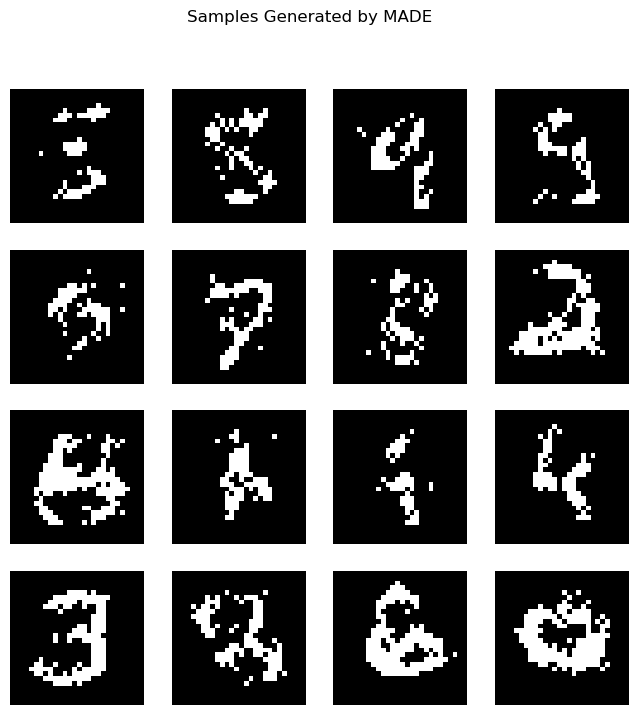

In [6]:
def generate_samples(model, num_samples=16):
    model.eval()
    # Initialize samples with zeros
    samples = torch.zeros(num_samples, 784).to(device)
    
    with torch.no_grad():
        # We must iterate through each pixel sequentially
        for i in range(784):
            logits = model(samples)
            # Get the probability for the i-th pixel
            probs = torch.sigmoid(logits[:, i])
            # Sample from Bernoulli distribution
            samples[:, i] = torch.bernoulli(probs)
    
    # Reshape for plotting
    samples = samples.view(-1, 28, 28).cpu().numpy()
    
    # Plotting
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.suptitle("Samples Generated by MADE")
    plt.show()

generate_samples(model)

They're not great samples, but pretty neat for a tractable generative model of this size! Improved samples would require increasing model capacity and other architectural tweaks that are not the focus of this class.

### 1.5 Out-of-Distribution (OOD) detection
We will try to perform OOD detection against FashionMNIST dataset.

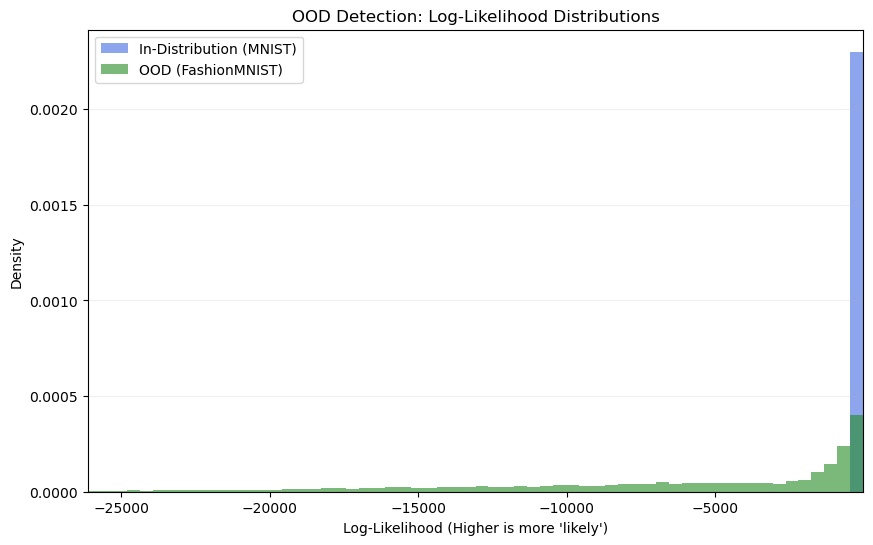

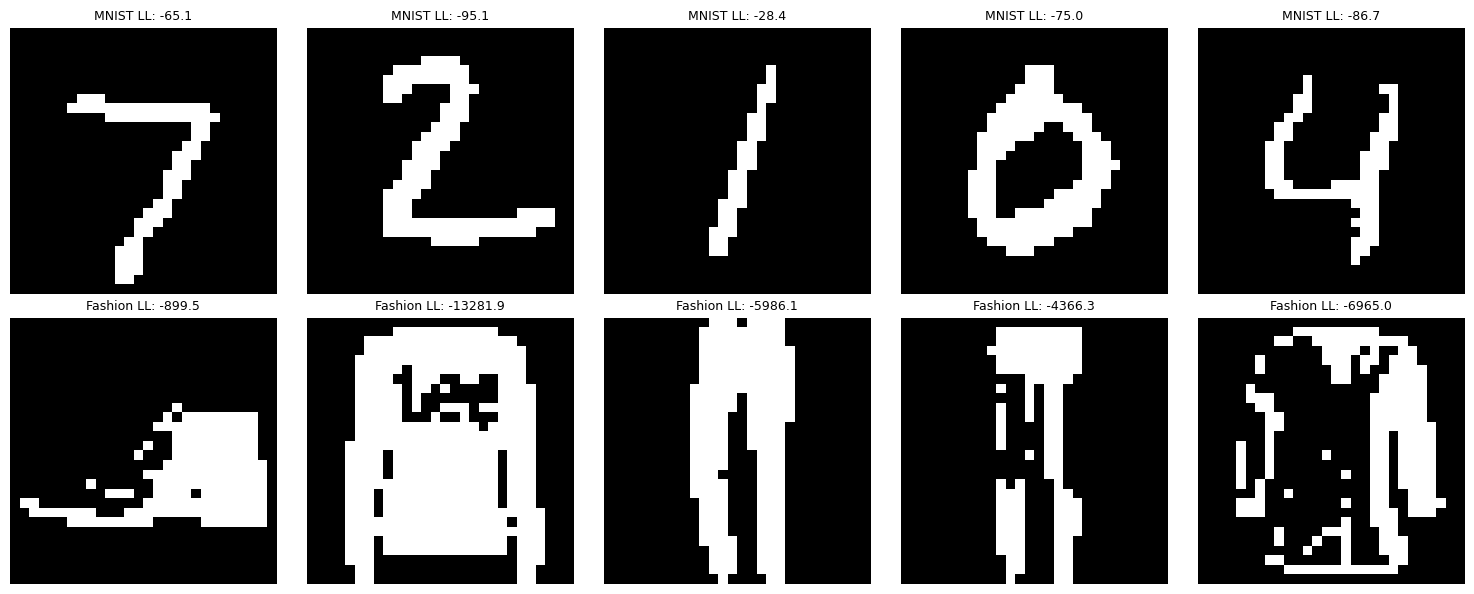

In [7]:
# 1. Define Datasets and Loaders (Removed EMNIST due to download issues)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
fashion_test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)
fashion_loader = DataLoader(fashion_test, batch_size=128, shuffle=False)

def get_log_likelihoods(model, data_loader):
    model.eval()
    log_probs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            logits = model(data)
            # Log-likelihood for Bernoulli: -BCE
            # reduction='none' allows us to sum over the pixel dimension (dim=1) 
            # while keeping the batch dimension intact.
            lp = -F.binary_cross_entropy_with_logits(logits, data, reduction='none').sum(dim=1)
            log_probs.extend(lp.cpu().numpy())
    return np.array(log_probs)

# 2. Compute Likelihoods
mnist_ll = get_log_likelihoods(model, test_loader)
fashion_ll = get_log_likelihoods(model, fashion_loader)

# 3. Plot Histograms
plt.figure(figsize=(10, 6))

# Determine a sensible range (ignoring extreme outliers)
# We look at the 1st and 99th percentiles to focus on the main distribution
combined_ll = np.concatenate([mnist_ll, fashion_ll])
min_range = np.percentile(combined_ll, 1)
max_range = np.percentile(combined_ll, 99)

plt.hist(mnist_ll, bins=60, range=(min_range, max_range), alpha=0.6, 
         label='In-Distribution (MNIST)', color='royalblue', density=True)
plt.hist(fashion_ll, bins=60, range=(min_range, max_range), alpha=0.6, 
         label='OOD (FashionMNIST)', color='forestgreen', density=True)

plt.title("OOD Detection: Log-Likelihood Distributions")
plt.xlabel("Log-Likelihood (Higher is more 'likely')")
plt.ylabel("Density")
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.xlim(min_range, max_range)
plt.show()

# 4. Visual Comparison Grid
def plot_multi_comparison(datasets_list, ll_list, names, n=5):
    fig, axes = plt.subplots(len(datasets_list), n, figsize=(15, 3 * len(datasets_list)))
    for row_idx, (dataset, lls, name) in enumerate(zip(datasets_list, ll_list, names)):
        for col_idx in range(n):
            img, _ = dataset[col_idx]
            ax = axes[row_idx, col_idx]
            ax.imshow(img.view(28, 28), cmap='gray')
            ax.set_title(f"{name} LL: {lls[col_idx]:.1f}", fontsize=9)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first 5 samples from each
plot_multi_comparison(
    [mnist_test, fashion_test], 
    [mnist_ll, fashion_ll], 
    ["MNIST", "Fashion"]
)

# 2 Normalizing Flows

Another interesting class of tractable generative models are normalizing flows. While MADE uses masking to enforce the chain rule, Normalizing Flows use invertible transformations and the Change of Variables formula to map a simple distribution to a complex one.


The core of a Normalizing Flow is a sequence of invertible functions
$$
f = f_K \circ \cdots \circ f_1.
$$
Given a base distribution $z \sim p_z(z)$ (typically a standard Gaussian), we transform it via $x = f(z)$. Using the change of variables formula, the exact log-likelihood of $x$ is
$$
\log p_x(x) = \log p_z\!\left(f^{-1}(x)\right)
+ \log \left| \det \left( \frac{\partial x}{\partial f^{-1}} \right) \right|.
$$

To make likelihood computation efficient, the Jacobian
$$
\frac{\partial x}{\partial f^{-1}}
$$
must have a determinant that is easy to compute.

**RealNVP** achieves this by using affine coupling layers whose Jacobian matrices are triangular. The input vector $x$ is split into two parts:
$$
x = [x_{1:d},\; x_{d+1:D}].
$$

The first part is left unchanged:
$$
y_{1:d} = x_{1:d}.
$$

The second part is scaled and shifted conditioned on the first:
$$
y_{d+1:D} = x_{d+1:D} \odot \exp\bigl(s(x_{1:d})\bigr) + t(x_{1:d}),
$$
where $s(\cdot)$ and $t(\cdot)$ are neural networks.

The log-determinant of the Jacobian for this transformation is simply
$$
\sum s(x_{1:d}).
$$
Because the functions $s$ and $t$ do not need to be invertible, they can be arbitrarily expressive, allowing RealNVP to learn highly complex distributions.

### 2.1 Affine Coupling Layer

We will implement the ```AffineCoupling``` layer and the ```RealNVP``` wrapper. For binarized MNIST, we use Dequantization by adding Uniform noise $u \in [0,1)$ to the binary pixels to make the discrete data continuous, which is required for flows.


In [8]:
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.register_buffer('mask', mask)
        # s and t are arbitrary neural networks
        self.s_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, dim), nn.Tanh()
        )
        self.t_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x, reverse=False):
        # Apply mask to keep part of the input constant
        x_masked = x * self.mask
        s = self.s_net(x_masked) * (1 - self.mask)
        t = self.t_net(x_masked) * (1 - self.mask)

        if not reverse: # z -> x (mapping prior to data)
            y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
            log_det = s.sum(dim=1)
            return y, log_det
        else: # x -> z (mapping data to prior)
            y = x_masked + (1 - self.mask) * ((x - t) * torch.exp(-s))
            return y

### 2.2 RealNVP

In [9]:
class RealNVP(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers):
        super().__init__()
        self.dim = dim # Store the dimension
        self.layers = nn.ModuleList()
        # Alternate masks (010101... and 101010...)
        mask = torch.arange(dim).float() % 2
        for i in range(n_layers):
            self.layers.append(AffineCoupling(dim, hidden_dim, mask))
            mask = 1 - mask

    def log_prob(self, x):
        # Only dequantize if we are doing high-dim image data (optional check)
        if self.dim > 2:
            x = x + torch.rand_like(x)
        
        log_det_sum = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_sum += log_det
            
        prior = torch.distributions.Normal(0, 1)
        log_prior = prior.log_prob(x).sum(dim=1)
        
        return log_prior + log_det_sum

    def sample(self, num_samples):
        # Use self.dim instead of 784
        z = torch.randn(num_samples, self.dim).to(device)
        for layer in reversed(self.layers):
            z = layer(z, reverse=True)
        return z

### 2.3 Training
Unlike MADE, which uses Cross-Entropy, RealNVP is trained by directly maximizing the ```log_prob``` output.

### 2.3.1 2D training

Before we begin training on MNIST, let us get some geometric intuition by studying the invertible transformations learnt on cats. We created these data samples by blurring an image of the sketch of a cat in ```cat.png``` and then using rejection sampling.

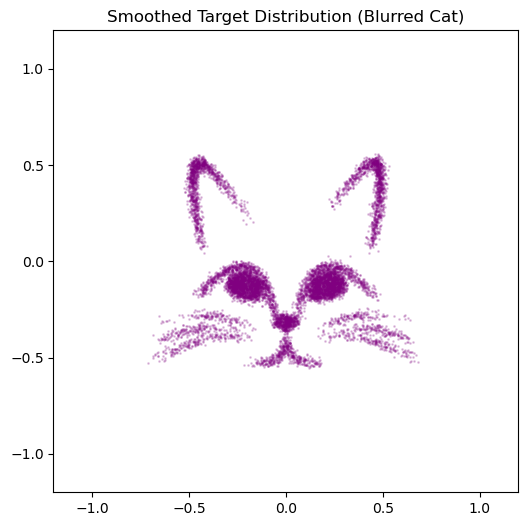

In [10]:
import PIL.Image
import numpy as np
import torch
from scipy.ndimage import gaussian_filter

def get_cat_samples(n_samples=10000, sigma=2.0):
    try:
        # Load image and convert to grayscale
        cat = PIL.Image.open("cat.png").convert('L')
        arr = 1.0 - (np.array(cat) / 255.0) # Invert so cat is high density (1)
        
        # Apply Gaussian Blur to smooth the distribution
        smoothed_arr = gaussian_filter(arr, sigma=sigma)
        # Normalize to make it a valid probability map
        prob_map = smoothed_arr / smoothed_arr.sum()
    except FileNotFoundError:
        print("Cat image not found, using a fallback density.")
        # Fallback to a simple 2D Gaussian if file is missing
        return torch.randn(n_samples, 2) * 0.5

    # Rejection Sampling or Weighted Sampling
    flat_probs = prob_map.flatten()
    indices = np.random.choice(len(flat_probs), size=n_samples, p=flat_probs)
    
    # Convert 1D indices back to 2D coordinates
    rows, cols = np.unravel_index(indices, prob_map.shape)
    
    # Map to [-1, 1] range
    points = np.zeros((n_samples, 2))
    points[:, 0] = (cols / prob_map.shape[1]) * 2 - 1
    points[:, 1] = 1 - (rows / prob_map.shape[0]) * 2
    
    # Add a tiny bit of noise to prevent points from collapsing onto pixel grid
    points += np.random.normal(0, 0.01, points.shape)
    
    return torch.from_numpy(points).float()

# Generate blurred training data
# Try increasing sigma to 3 or 5 for even more "fuzziness"
cat_points = get_cat_samples(10000, sigma=3.0)

plt.figure(figsize=(6, 6))
plt.scatter(cat_points[:, 0], cat_points[:, 1], s=1, alpha=0.2, color='purple')
plt.title("Smoothed Target Distribution (Blurred Cat)")
plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2)
plt.show()

Iteration 0 | Loss: 2.0485
Iteration 500 | Loss: -0.9202
Iteration 1000 | Loss: -0.9668
Iteration 1500 | Loss: -0.9549
Iteration 2000 | Loss: -0.9935


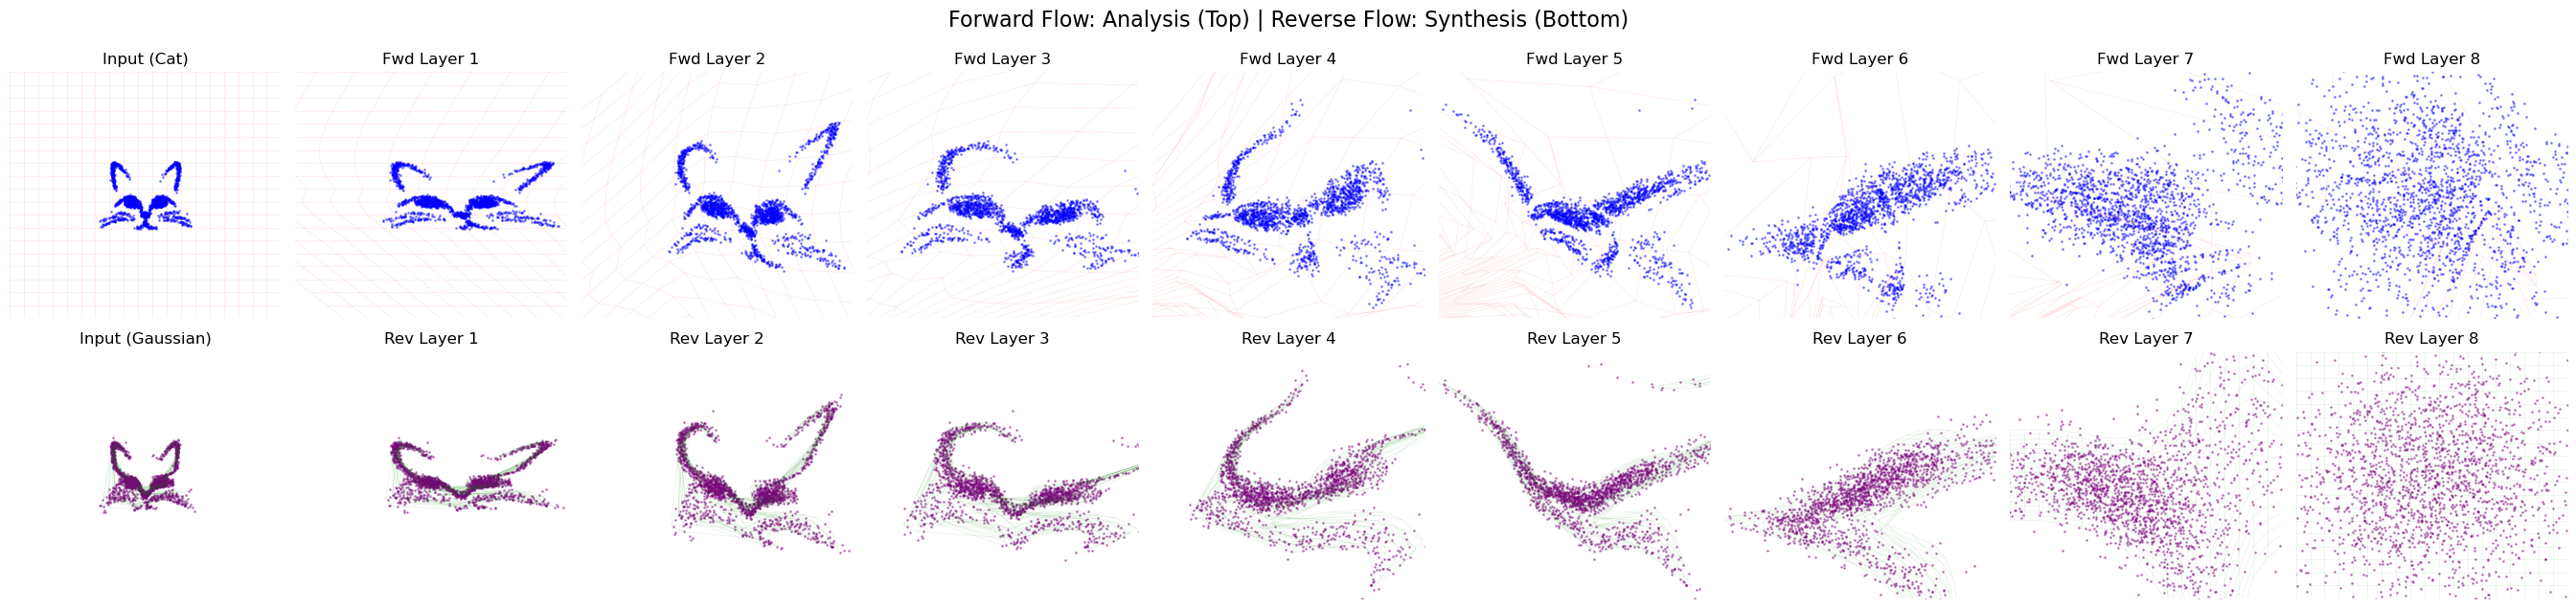

In [11]:
# Smaller 2D model
# Re-run training with the blurred data
cat_flow = RealNVP(dim=2, hidden_dim=128, n_layers=8).to(device)
optimizer = torch.optim.Adam(cat_flow.parameters(), lr=2e-4)

for i in range(2001):
    cat_flow.train()
    # Sample fresh points every iteration to avoid overfitting to a static set
    x = get_cat_samples(1024, sigma=3.0).to(device)
    
    optimizer.zero_grad()
    loss = -cat_flow.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    
    if i % 500 == 0:
        print(f"Iteration {i} | Loss: {loss.item():.4f}")

# Visualization of intermediate transformations
def visualize_dual_warps(model, cat_data, num_samples=2000):
    model.eval()
    device = next(model.parameters()).device
    
    # Setup for Forward (Cat -> Gaussian)
    fwd_x = cat_data[:num_samples].to(device)
    
    # Setup for Reverse (Gaussian -> Cat)
    rev_z = torch.randn(num_samples, 2).to(device)
    
    # Setup Grid
    grid_size = 20
    x_range = np.linspace(-2, 2, grid_size)
    y_range = np.linspace(-2, 2, grid_size)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_tensor = torch.from_numpy(np.stack([grid_x, grid_y], axis=-1)).float().view(-1, 2).to(device)
    
    layers = model.layers
    num_layers = len(layers)
    fig, axes = plt.subplots(2, num_layers + 1, figsize=(3 * (num_layers + 1), 6))
    
    # Trackers
    curr_fwd_x = fwd_x
    curr_fwd_grid = grid_tensor
    
    curr_rev_z = rev_z
    curr_rev_grid = grid_tensor
    
    # Loop through layers
    for i in range(num_layers + 1):
        # --- ROW 1: FORWARD (Cat to Gaussian) ---
        ax_fwd = axes[0, i]
        pts_fwd = curr_fwd_x.cpu().detach().numpy()
        grid_fwd = curr_fwd_grid.cpu().detach().numpy().reshape(grid_size, grid_size, 2)
        
        ax_fwd.scatter(pts_fwd[:, 0], pts_fwd[:, 1], s=1, alpha=0.4, color='blue')
        for j in range(grid_size):
            ax_fwd.plot(grid_fwd[j, :, 0], grid_fwd[j, :, 1], 'r', alpha=0.1, lw=0.5)
            ax_fwd.plot(grid_fwd[:, j, 0], grid_fwd[:, j, 1], 'r', alpha=0.1, lw=0.5)
        
        ax_fwd.set_xlim(-2, 2); ax_fwd.set_ylim(-2, 2)
        ax_fwd.set_title(f"Fwd Layer {i}") if i > 0 else ax_fwd.set_title("Input (Cat)")
        ax_fwd.axis('off')

        # --- ROW 2: REVERSE (Gaussian to Cat) ---
        # Note: We visualize the reverse path starting from the last column
        ax_rev = axes[1, num_layers - i]
        pts_rev = curr_rev_z.cpu().detach().numpy()
        grid_rev = curr_rev_grid.cpu().detach().numpy().reshape(grid_size, grid_size, 2)
        
        ax_rev.scatter(pts_rev[:, 0], pts_rev[:, 1], s=1, alpha=0.4, color='purple')
        for j in range(grid_size):
            ax_rev.plot(grid_rev[j, :, 0], grid_rev[j, :, 1], 'g', alpha=0.1, lw=0.5)
            ax_rev.plot(grid_rev[:, j, 0], grid_rev[:, j, 1], 'g', alpha=0.1, lw=0.5)
            
        ax_rev.set_xlim(-2, 2); ax_rev.set_ylim(-2, 2)
        ax_rev.set_title(f"Rev Layer {num_layers-i}") if i < num_layers else ax_rev.set_title("Input (Gaussian)")
        ax_rev.axis('off')

        # Step forward and backward
        if i < num_layers:
            with torch.no_grad():
                # Forward step
                curr_fwd_x, _ = layers[i](curr_fwd_x)
                curr_fwd_grid, _ = layers[i](curr_fwd_grid)
                
                # Reverse step (starting from the back)
                rev_layer = layers[num_layers - 1 - i]
                curr_rev_z = rev_layer(curr_rev_z, reverse=True)
                curr_rev_grid = rev_layer(curr_rev_grid, reverse=True)

    plt.tight_layout()
    plt.suptitle("Forward Flow: Analysis (Top) | Reverse Flow: Synthesis (Bottom)", fontsize=16, y=1.05)
    plt.show()

# Visualize the dual transformation
visualize_dual_warps(cat_flow, get_cat_samples(3000, sigma=2.0))

Not bad... Despite the cat being a pretty difficult and sharp data, we are able to learn a series of invertible transformations to go from a Gaussian to a cat.

### 2.3.3 MNIST training

In [12]:
# Initialize
flow_model = RealNVP(dim=784, hidden_dim=256, n_layers=8).to(device)
flow_optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-4)

# Training Loop
def train_flow(epochs=5):
    flow_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            flow_optimizer.zero_grad()
            # Loss is negative log-likelihood
            loss = -flow_model.log_prob(x).mean()
            loss.backward()
            flow_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

train_flow()

Epoch 1 | Loss: 351.1767
Epoch 2 | Loss: 289.6910
Epoch 3 | Loss: 281.7054
Epoch 4 | Loss: 277.0471
Epoch 5 | Loss: 273.8492


### 2.4 Inference
Generating samples from a Normalizing Flow is extremely fast compared to MADE because it is a single forward pass.

For RealNVP, a type of normalizing flow, likelihood computation is based on the change of variables formula. The model assumes that the observed data are generated by transforming samples from a simple latent distribution—typically a standard Gaussian—through an invertible function $f$ that warps this simple distribution into the complex structure of the data (e.g., MNIST images).

To evaluate the likelihood of a given data point $x$, we apply the inverse transformation and map the data back into latent space:
$$
z = f^{-1}(x).
$$
The exact likelihood is then given by the density of $z$ under the base Gaussian distribution, multiplied by a correction term given by the determinant of the Jacobian of the inverse transformation:
$$
\log p_x(x) = \log p_z(z) + \log \left| \det \left( \frac{\partial z}{\partial x} \right) \right|.
$$

This Jacobian determinant accounts for how volumes are expanded or contracted by the transformation, ensuring that probability mass is preserved and that the resulting density integrates to 1. Because the transformation is invertible and the Jacobian determinant is computed exactly, RealNVP provides an exact likelihood rather than an approximation.


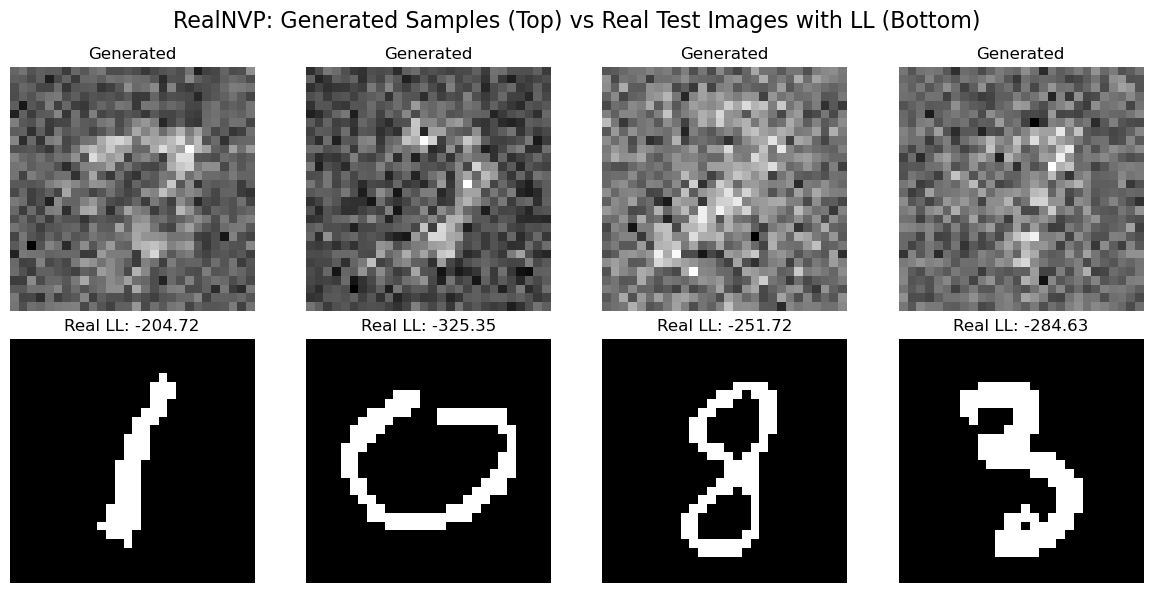

In [13]:
def visualize_flow_results(model, test_dataset):
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Generate Samples (The Model's Imagination)
    with torch.no_grad():
        gen_samples = model.sample(16).cpu().view(-1, 28, 28)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    plt.suptitle("RealNVP: Generated Samples (Top) vs Real Test Images with LL (Bottom)", fontsize=16)
    
    for i in range(4):
        axes[0, i].imshow(gen_samples[i], cmap='gray')
        axes[0, i].set_title("Generated")
        axes[0, i].axis('off')
        
    # 2. Evaluate Real Test Images (Likelihood Computation)
    # We take 4 random images from the test set
    indices = torch.randint(0, len(test_dataset), (4,))
    with torch.no_grad():
        for i, idx in enumerate(indices):
            x, _ = test_dataset[idx]
            x_input = x.unsqueeze(0).to(device)
            
            # Compute Exact Log-Likelihood
            log_prob = model.log_prob(x_input).item()
            
            axes[1, i].imshow(x.view(28, 28), cmap='gray')
            axes[1, i].set_title(f"Real LL: {log_prob:.2f}")
            axes[1, i].axis('off')
            
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_flow_results(flow_model, mnist_test)

### 2.5 OOD detection

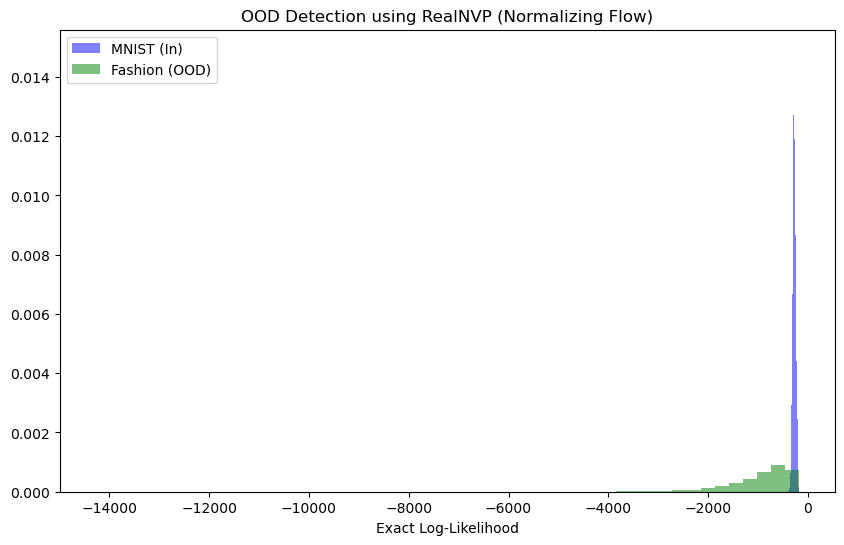

In [14]:
def get_flow_log_likelihoods(model, data_loader):
    model.eval()
    log_probs = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            lp = model.log_prob(x)
            log_probs.extend(lp.cpu().numpy())
    return np.array(log_probs)

# Compute Likelihoods for Flow
flow_mnist_ll = get_flow_log_likelihoods(flow_model, test_loader)
flow_fashion_ll = get_flow_log_likelihoods(flow_model, fashion_loader)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(flow_mnist_ll, bins=50, alpha=0.5, label='MNIST (In)', color='blue', density=True)
plt.hist(flow_fashion_ll, bins=50, alpha=0.5, label='Fashion (OOD)', color='green', density=True)
plt.title("OOD Detection using RealNVP (Normalizing Flow)")
plt.xlabel("Exact Log-Likelihood")
plt.legend()
plt.show()

### Masked Autoregressive Flows (MAFs): Combining MADE and Normalizing Flows

While RealNVP worked beautifully for the 2D cat, it struggles with images for two main reasons: Pixel Dependency and Volume Preservation. RealNVP is "volume-preserving" in a way that often leads to "whitening" the data. Without enough layers or the right architecture (like multi-scale architectures or convolutions), it treats the 784 pixels as independent values rather than a cohesive structure.

*Why RealNVP failed?*

- A standard affine coupling layer (splitting the image 50/50) is very "blind." It tries to predict the bottom half of the image based on the top half using a simple MLP. Since MLP-based flows don't have a concept of spatial locality (like Convolutional layers do), they struggle to learn the sharp edges of digits.
- RealNVP is "volume-preserving" in a way that often leads to "whitening" the data. Without enough layers or the right architecture (like multi-scale architectures or convolutions), it treats the 784 pixels as independent values rather than a cohesive structure.
- We are adding uniform noise to binary pixels. If the model isn't powerful enough, it spends all its capacity modeling that noise rather than the underlying digit structure.

*How to fix it?*

If we want the stability of MADE with the power of Normalizing Flows, we can combine them. In a Masked Autoregressive Flow, each layer of the flow is actually a MADE network. This gives the model a much stronger "inductive bias" for sequential pixel dependencies. You will notice that MAF gets much better Log-Likelihoods and sharper OOD detection, but sampling becomes slow again (just like the original MADE). 

This is the fundamental tension in flows:

RealNVP: Fast sampling, but harder to train for complex densities.

MAF: Easy to train (exact density), but slow sampling.